In [1]:
import warnings
# warnings.simplefilter("ignore")
warnings.simplefilter("ignore", UserWarning)

In [2]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PATH_DATASET = Path("/kaggle/input/home-credit-credit-risk-model-stability")
PATH_PARQUETS = PATH_DATASET / "parquet_files"
PARQUETS_TRAIN = PATH_PARQUETS / "train"
PARQUETS_TEST = PATH_PARQUETS / "test"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Explore the training data

**Borrowed from the competition describtion:**

Table Description
This dataset contains a large number of tables as a result of utilizing diverse data sources and the varying levels of data aggregation used while preparing the dataset. Note: All files listed below are found in both .csv and .parquet formats.

### Depth values

- **depth=0** - These are static features directly tied to a specific case_id.
- **depth=1** - Each case_id has an associated historical record, indexed by num_group1.
- **depth=2** - Each case_id has an associated historical record, indexed by both num_group1 and num_group2.

You can read more about Credit bureau (CB) here https://en.wikipedia.org/wiki/Credit_bureau.

In [3]:
!cat /kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv

Variable,Description
actualdpd_943P,Days Past Due (DPD) of previous contract (actual).
actualdpdtolerance_344P,DPD of client with tolerance.
addres_district_368M,District of the person's address.
addres_role_871L,Role of person's address.
addres_zip_823M,Zip code of the address.
amount_1115A,Credit amount of the active contract provided by the credit bureau.
amount_416A,Deposit amount.
amount_4527230A,Tax deductions amount tracked by the government registry.
amount_4917619A,Tax deductions amount tracked by the government registry.
amtdebitincoming_4809443A,Incoming debit card transactions amount.
amtdebitoutgoing_4809440A,Outgoing debit card transactions amount.
amtdepositbalance_4809441A,Deposit balance of client.
amtdepositincoming_4809444A,Amount of incoming deposits to client's account.
amtdepositoutgoing_4809442A,Amount of outgoing deposits from client's account.
amtinstpaidbefduel24m_4187115A,Number of instalments paid before due date in the last 24 months.
annualeffectiverate_19

Various predictors were transformed, therefore we have the following notation for similar groups of transformations

- **P** - Transform DPD (Days past due)
- **M** - Masking categories
- **A** - Transform amount
- **D** - Transform date
- **T** - Unspecified Transform
- **L** - Unspecified Transform

Please note that transformations within a group are denoted by a capital letter at the end of the predictor name (e.g., maxdbddpdtollast6m_4187119P). We hope that this will simplify the manipulation with predictors.

In [4]:
def _short_array(arr):
    if len(arr) <= 5:
        return repr(arr)
    return f"[{', '.join(map(str, arr[:2]))}, ..., {', '.join(map(str, arr[-2:]))}]"

# taking inpiration with column names from https://www.kaggle.com/code/greysky/home-credit-baseline
def convert_dtypes(df):
    cols = []
    for col, dt in dict(df.dtypes).items():
        if col.startswith("for"):
            df[col] = df[col].fillna(0).astype("int16")
        elif "num" in col or "cnt" in col:
            df[col] = df[col].fillna(0).astype("int32")
        elif col.startswith("pct"):
            df[col] = df[col].astype("float16")
        elif col[-1] in ("A", "P"):
            df[col] = df[col].astype("float32")
        elif col[-1] in ("D", ):
            df[col] = pd.to_datetime(df[col])
        elif col[-1] in ("M", "L"):
            if col[-1] == "L" and dt.name.startswith("int"):
                df[col] = df[col].astype("int32")
            elif col[-1] == "L" and dt.name.startswith("float"):
                df[col] = df[col].astype("float32")
            else:
                uq = list(df[col].unique())
                print(f'{col} -> #{len(uq)} -> {_short_array(uq)}')
                df[col] = df[col].astype("category")
        if col[-1] in ("A", "P", "M", "L"):
            cols.append(col)
    return cols

### Base tables

Base tables store the basic information about the observation and case_id. This is a unique identification of every observation and you need to use it to join the other tables to base tables.

train_base.csv

In [5]:
df_train = pd.read_parquet(PARQUETS_TRAIN / "train_base.parquet")
print(f"size: {len(df_train)}")
display(df_train.head())

size: 1526659


,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [6]:
df_train["date_decision"] = pd.to_datetime(df_train["date_decision"]).dt.date
# delete redundat cols
del df_train["MONTH"], df_train["WEEK_NUM"]

In [7]:
def merge_parquets(df, name, prefix="train", folder=PATH_PARQUETS):
    df_ = pd.concat(
        [pd.read_parquet(p) for p in glob.glob(str(folder / prefix / f"{prefix}_{name}*.parquet"))],
    )
    if "num_group1" in df_.columns:
        del df_["num_group1"]
    df_.drop_duplicates(inplace=True)
    print(f"{name} size: {len(df_)} with features: {len(df_.columns)}")
    display(df_.head())
    cols = convert_dtypes(df_) + ["case_id"]
    df_ = df_[cols]
    if len(df_) > len(df_["case_id"].unique()):
        df_ = df_.groupby(['case_id'], as_index=False).first()
    df = df.merge(df_, how="left", on="case_id")
    print(f"fused size: {len(df)}")
    return df

## Depth 0

### static_0 | Properties: depth=0, internal data source

- train_static_0_0.csv
- train_static_0_1.csv

### static_cb_0 | Properties: depth=0, external data source

- train_static_cb_0.csv

In [8]:
df_train = merge_parquets(df_train, "static_0")

static_0 size: 1526659 with features: 168


,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastrepayingdate_696D,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
0,0,NaN,NaN,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,30000.0,CAL,0.0,0.0,None,None,None,NaN,0.0,30000.0,GBA,0.0,None,0.4500,None,None,N

bankacctype_710L -> #2 -> [None, 'CA']
cardtype_51L -> #3 -> [None, 'INSTANT', 'PERSONALIZED']
credtype_322L -> #4 -> ['CAL', 'REL', 'COL', None]
disbursementtype_67L -> #4 -> ['GBA', 'DD', 'SBA', None]
equalitydataagreement_891L -> #3 -> [None, True, False]
equalityempfrom_62L -> #3 -> [None, True, False]
inittransactioncode_186L -> #4 -> ['CASH', 'NDF', 'POS', None]
isbidproduct_1095L -> #2 -> [False, True]
isbidproductrequest_292L -> #3 -> [None, False, True]
isdebitcard_729L -> #2 -> [None, False]
lastapprcommoditycat_1041M -> #45 -> [a55475b1, P159_130_59, ..., P93_39_173, P58_25_91]
lastapprcommoditytypec_5251766M -> #214 -> [a55475b1, P126_18_172, ..., P158_79_160, P108_43_172]
lastcancelreason_561M -> #74 -> [a55475b1, P94_109_143, ..., P204_22_168, P203_151_99]
lastrejectcommoditycat_161M -> #45 -> [a55475b1, P100_96_175, ..., P187_21_169, P58_25_91]
lastrejectcommodtypec_5251769M -> #187 -> [a55475b1, P111_89_135, ..., P28_129_133, P61_82_106]
lastrejectreason_759M -> #18 -> 

In [9]:
df_train = merge_parquets(df_train, "static_cb_0")

static_cb_0 size: 1500476 with features: 53


,case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,357,None,None,None,1988-04-01,NaN,None,None,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6301.4000,None,2019-01-25,None,None,None,NaN,NaN,NaN
1,381,None,None,None,1973-11-01,NaN,None,None,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4019.6000,None,2019-01-25,None,None,None,NaN,NaN,NaN
2,388,None,None,None,1989-04-01,NaN,1989-04-01,None,6.0,8.0,2.0,10.0,4.0,a55475b1,a55475b1,a55475b1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,a55475b1,a55475b1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,14548.0000,None,2019-01-28,None,None,None,NaN,3.0,5.0
3,405,None,None,None,1974-03-01,NaN,1974-03-01,None,0.0,0.0,0.0,1.0,0.0,a55475b1,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,a55475b1,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,10498.2400,None,2019-01-21,None,None,None,NaN,2.0,0.0
4,409,None,None,None,1993-06-01,NaN,1993-06-01,None,2.0,3.0,0.0,3.0,1.0,a55475b1,717ddd49,a55475b1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,a7fcb6e5,a55475b1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6344.8804,None,2019-01-21,None,None,None,NaN,0.0,4.0


description_5085714M -> #2 -> ['a55475b1', '2fc785b2']
education_1103M -> #5 -> ['a55475b1', '717ddd49', '6b2ae0fa', '39a0853f', 'c8e1a1d0']
education_88M -> #5 -> ['a55475b1', '6b2ae0fa', '717ddd49', 'a34a13c8', 'c8e1a1d0']
maritalst_385M -> #6 -> [a55475b1, a7fcb6e5, ..., 38c061ee, ecd83604]
maritalst_893M -> #6 -> [a55475b1, 46b968c3, ..., e18430ff, ecd83604]
requesttype_4525192L -> #4 -> [None, 'DEDUCTION_6', 'PENSION_6', 'SOCIAL_6']
fused size: 1526659


## Depth 1

### applprev_1 | Properties: depth=1, internal data source

- train_applprev_1_0.csv
- train_applprev_1_1.csv

### other_1 | Properties: depth=1, internal data source

- train_other_1.csv

### tax_registry_a_1 | Properties: depth=1, external data source, Tax registry provider A

- train_tax_registry_a_1.csv

### tax_registry_b_1 | Properties: depth=1, external data source, Tax registry provider B

- train_tax_registry_b_1.csv

### tax_registry_c_1 | Properties: depth=1, external data source, Tax registry provider C

- train_tax_registry_c_1.csv

### credit_bureau_a_1 | Properties: depth=1, external data source, Credit bureau provider A

- train_credit_bureau_a_1_0.csv
- train_credit_bureau_a_1_1.csv
- train_credit_bureau_a_1_2.csv
- train_credit_bureau_a_1_3.csv

### credit_bureau_b_1 | Properties: depth=1, external data source, Credit bureau provider B

- train_credit_bureau_b_1.csv

### deposit_1 | Properties: depth=1, internal data source

- train_deposit_1.csv

### person_1 | Properties: depth=1, internal data source

- train_person_1.csv

### debitcard_1 | Properties: depth=1, internal data source

- train_debitcard_1.csv

In [10]:
# df_train = merge_tables(df_train, "applprev_1")

In [11]:
# df_train = merge_parquets(df_train, "other_1")

In [12]:
# df_train = merge_parquets(df_train, "deposit_1")

In [13]:
# df_train = merge_parquets(df_train, "debitcard_1")

In [14]:
df_train = merge_parquets(df_train, "person_1")

person_1 size: 2967766 with features: 36


,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,0,1986-07-01,None,NaN,P88_18_84,False,False,P167_100_165,P97_36_170,2017-09-15,MORE_FIVE,OTHER,P142_57_166,P167_100_165,MARRIED,None,None,None,SALARIED_GOVT,None,P10_39_147,10800.0,None,0.0,1.0,1.0,P88_18_84,P167_100_165,None,None,None,CL,None,True,F,PRIMARY_MOBILE
1,0,None,None,NaN,a55475b1,None,None,a55475b1,a55475b1,None,None,None,a55475b1,a55475b1,None,None,None,None,None,None,a55475b1,NaN,None,1.0,1.0,4.0,a55475b1,a55475b1,SPOUSE,None,False,EM,None,None,None,PHONE
2,0,None,None,NaN,a55475b1,None,None,a55475b1,a55475b1,None,None,None,a55475b1,a55475b1,None,None,None,None,None,None,a55475b1,NaN,None,2.0,4.0,5.0,a55475b1,a55475b1,COLLEAGUE,SPOUSE,False,PE,None,None,None,PHONE
3,0,None,None,NaN,a55475b1,None,None,a55475b1,a55475b1,None,None,None,a55475b1,a55475b1,None,None,None,None,None,None,a55475b1,NaN,None,NaN,5.0,NaN,a55475b1,a55475b1,None,COLLEAGUE,None,PE,None,None,None,PHONE
4,1,1957-08-01,None,NaN,P103_93_94,False,False,P176_37_166,P97_36_170,2008-10-29,MORE_FIVE,OTHER,P49_46_174,P160_59_140,DIVORCED,None,None,None,SALARIED_GOVT,None,P10_39_147,10000.0,None,0.0,1.0,1.0,P103_93_94,P176_37_166,None,None,None,CL,None,True,M,PRIMARY_MOBILE


contaddr_district_15M -> #975 -> [P88_18_84, a55475b1, ..., P191_97_164, P52_135_37]
contaddr_matchlist_1032L -> #2 -> [False, None]
contaddr_smempladdr_334L -> #3 -> [False, None, True]
contaddr_zipcode_807M -> #3530 -> [P167_100_165, a55475b1, ..., P54_145_111, P47_73_82]
education_927M -> #6 -> [P97_36_170, a55475b1, ..., P106_81_188, P157_18_172]
empl_employedtotal_800L -> #4 -> ['MORE_FIVE', None, 'LESS_ONE', 'MORE_ONE']
empl_industry_691L -> #25 -> [OTHER, None, ..., ARMY_POLICE, RECRUITMENT]
empladdr_district_926M -> #223 -> [P142_57_166, a55475b1, ..., P0_140_162, P156_54_111]
empladdr_zipcode_114M -> #3339 -> [P167_100_165, a55475b1, ..., P1_76_57, P45_21_48]
familystate_447L -> #6 -> [MARRIED, None, ..., WIDOWED, LIVING_WITH_PARTNER]
gender_992L -> #3 -> [None, 'F', 'M']
housetype_905L -> #7 -> [None, OWNED, ..., STATE_FLAT, COOP_FLAT]
housingtype_772L -> #7 -> [None, PARENTAL, ..., COMPANY_FLAT, COOP_FLAT]
isreference_387L -> #3 -> [None, True, False]
language1_981M -> #3 ->

In [15]:
# df_train = merge_parquets(df_train, "tax_registry_a_1")
# df_train = merge_parquets(df_train, "tax_registry_b_1")
# df_train = merge_parquets(df_train, "tax_registry_c_1")  # empty in test set

In [16]:
# TODO

## Depth 2

### applprev_2 | Properties: depth=2, internal data source

- train_applprev_2.csv

### person_2 | Properties: depth=2, internal data source

- train_person_2.csv

### redit_bureau_a_2 | Properties: depth=2, external data source, Credit bureau provider A

- train_credit_bureau_a_2_0.csv
- train_credit_bureau_a_2_1.csv
- train_credit_bureau_a_2_2.csv
- train_credit_bureau_a_2_3.csv
- train_credit_bureau_a_2_4.csv
- train_credit_bureau_a_2_5.csv
- train_credit_bureau_a_2_6.csv
- train_credit_bureau_a_2_7.csv
- train_credit_bureau_a_2_8.csv
- train_credit_bureau_a_2_9.csv
- train_credit_bureau_a_2_10.csv

### credit_bureau_b_2 | Properties: depth=2, external data source, Credit bureau provider B

- train_credit_bureau_b_2.csv

In [17]:
# TODO

## Brows the data

In [18]:
print(f"data size: {len(df_train)}")
print(f"unique: {len(df_train['case_id'].unique())}")

data size: 1526659
unique: 1526659


In [19]:
display(df_train.head().T)

,0,1,2,3,4
case_id,0,1,2,3,4
date_decision,2019-01-03,2019-01-03,2019-01-04,2019-01-03,2019-01-04
target,0,0,0,0,1
actualdpdtolerance_344P,NaN,NaN,NaN,NaN,NaN
amtinstpaidbefduel24m_4187115A,NaN,NaN,NaN,NaN,NaN
annuity_780A,1917.599976,3134.0,4937.0,4643.600098,3390.199951
annuitynextmonth_57A,0.0,0.0,0.0,0.0,0.0
applicationcnt_361L,0,0,0,0,0
applications30d_658L,0.0,0.0,0.0,1.0,1.0
applicationscnt_1086L,0,0,0,0,0


<Axes: xlabel='date_decision'>

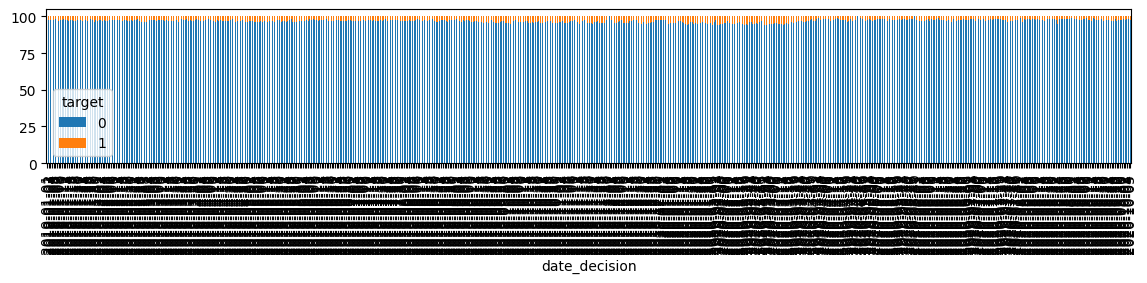

In [20]:
t = df_train.groupby('date_decision')['target'].value_counts(normalize=True).mul(100)
t.unstack().plot.bar(stacked=True, figsize=(14, 2), legend=True)

<Axes: xlabel='date of decision', ylabel='day mean / proxi ratio'>

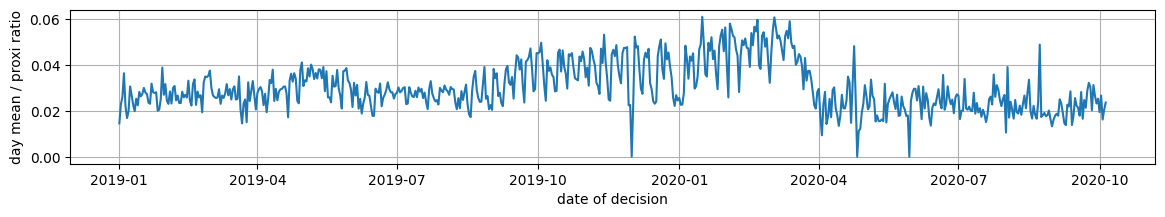

In [21]:
df_train.groupby('date_decision')['target'].mean().plot(
    figsize=(14, 2), grid=True,
    xlabel="date of decision",
    ylabel="day mean / proxi ratio",
)

In [22]:
display(df_train.dtypes)

case_id                               int64
date_decision                        object
target                                int64
actualdpdtolerance_344P             float32
amtinstpaidbefduel24m_4187115A      float32
annuity_780A                        float32
annuitynextmonth_57A                float32
applicationcnt_361L                   int32
applications30d_658L                float32
applicationscnt_1086L                 int32
applicationscnt_464L                  int32
applicationscnt_629L                  int32
applicationscnt_867L                  int32
avgdbddpdlast24m_3658932P           float32
avgdbddpdlast3m_4187120P            float32
avgdbdtollast24m_4525197P           float32
avgdpdtolclosure24_3658938P         float32
avginstallast24m_3658937A           float32
avglnamtstart24m_4525187A           float32
avgmaxdpdlast9m_3716943P            float32
avgoutstandbalancel6m_4187114A      float32
avgpmtlast12m_4525200A              float32
bankacctype_710L                

In [23]:
# convert_dtypes(df_train)
# display(df_train.head().T)

# Train simple XGBoost

In [24]:
from sklearn.model_selection import train_test_split

df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
train_cols = [c for c in df_train.columns if c not in ("case_id", "date_decision", "target")]
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train[train_cols], df_train['target'], test_size=0.2)

In [25]:
!pip install -U xgboost -f /kaggle/input/xgboost-python-package/ --no-index

Looking in links: /kaggle/input/xgboost-python-package/


In [26]:
import xgboost as xgb

print(xgb.__version__)

2.0.3


In [27]:
model = xgb.XGBClassifier(
    device="cuda",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    #learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    #gamma=0.7,
    #reg_alpha=0.7,
    max_depth=20,
    n_estimators=800,
    random_state=42,
)

# Training the model on the training data
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=5,
    verbose=True,
)

print(model)

[0]	validation_0-auc:0.68272
[1]	validation_0-auc:0.70679
[2]	validation_0-auc:0.71803
[3]	validation_0-auc:0.72767
[4]	validation_0-auc:0.73222
[5]	validation_0-auc:0.73577
[6]	validation_0-auc:0.73953
[7]	validation_0-auc:0.74443
[8]	validation_0-auc:0.74776
[9]	validation_0-auc:0.74994
[10]	validation_0-auc:0.75135
[11]	validation_0-auc:0.75284
[12]	validation_0-auc:0.75388
[13]	validation_0-auc:0.75543
[14]	validation_0-auc:0.75644
[15]	validation_0-auc:0.75818
[16]	validation_0-auc:0.75931
[17]	validation_0-auc:0.75952
[18]	validation_0-auc:0.76041
[19]	validation_0-auc:0.76064
[20]	validation_0-auc:0.76008
[21]	validation_0-auc:0.76068
[22]	validation_0-auc:0.75998
[23]	validation_0-auc:0.75973
[24]	validation_0-auc:0.75931
[25]	validation_0-auc:0.75917
[26]	validation_0-auc:0.75942
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device='cuda', early_stopping_rounds=None,
 

In [28]:
train_columns_dtypes = dict(df_train.dtypes)
del df_train

# Loading test data

## base data

In [29]:
df_test = pd.read_parquet(PARQUETS_TEST / "test_base.parquet")
print(f"size: {len(df_test)}")
display(df_test.head())

size: 10


,case_id,date_decision,MONTH,WEEK_NUM
0,57543,2020-10-06,202010,92
1,57549,2020-10-06,202010,92
2,57551,2020-10-06,202010,92
3,57552,2020-10-07,202010,92
4,57569,2020-10-06,202010,92


In [30]:
df_test["date_decision"] = pd.to_datetime(df_test["date_decision"]).dt.date
# delete redundat cols
del df_test["MONTH"], df_test["WEEK_NUM"]

## Depth 0

In [31]:
for name in ["static_0", "static_cb_0"]:
    df_test = merge_parquets(df_test, name, "test")

static_0 size: 30 with features: 168


,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastrepayingdate_696D,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
0,57543,NaN,NaN,7637.20000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,100000.0,CAL,0.0,0.0,None,None,None,NaN,0.0,100000.0,GBA,0.0,None,0.45,Non

bankacctype_710L -> #2 -> [None, 'CA']
cardtype_51L -> #2 -> [None, 'INSTANT']
credtype_322L -> #2 -> ['CAL', 'REL']
disbursementtype_67L -> #3 -> ['GBA', 'DD', None]
equalitydataagreement_891L -> #1 -> [None]
equalityempfrom_62L -> #1 -> [None]
inittransactioncode_186L -> #2 -> ['CASH', 'NDF']
isbidproduct_1095L -> #2 -> [False, True]
isbidproductrequest_292L -> #2 -> [None, False]
isdebitcard_729L -> #2 -> [None, False]
lastapprcommoditycat_1041M -> #2 -> ['a55475b1', 'P12_6_178']
lastapprcommoditytypec_5251766M -> #2 -> ['a55475b1', 'P111_89_135']
lastcancelreason_561M -> #5 -> ['P94_109_143', 'a55475b1', 'P11_56_131', 'P19_105_83', 'P141_135_146']
lastrejectcommoditycat_161M -> #3 -> ['P159_130_59', 'a55475b1', 'P109_133_183']
lastrejectcommodtypec_5251769M -> #4 -> ['P75_90_70', 'a55475b1', 'P78_110_79', 'P98_55_164']
lastrejectreason_759M -> #5 -> ['P99_56_166', 'P45_84_106', 'a55475b1', 'P94_109_143', 'P198_131_9']
lastrejectreasonclient_4145040M -> #3 -> ['P94_109_143', 'a55475

,case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,57543,NaN,None,None,NaN,22130.26,1996-08-01,None,9.0,9.0,9.0,10.0,9.0,2fc785b2,a55475b1,a55475b1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,a55475b1,a55475b1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,2020-10-20,None,NaN,1.0,6.0
1,57549,NaN,None,None,NaN,NaN,1992-03-01,None,0.0,0.0,0.0,0.0,0.0,2fc785b2,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,2020-10-20,None,NaN,2.0,0.0
2,57551,NaN,None,None,NaN,NaN,1990-08-01,None,2.0,2.0,1.0,2.0,2.0,2fc785b2,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,a55475b1,a55475b1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,2020-10-20,None,NaN,0.0,2.0
3,57552,NaN,None,2012-03-02,NaN,NaN,1948-10-01,None,0.0,0.0,0.0,0.0,0.0,2fc785b2,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a55475b1,a55475b1,0.0,NaN,NaN,16327.0,NaN,14.0,NaN,NaN,NaN,None,NaN,None,2020-10-19,None,NaN,0.0,0.0
4,57569,NaN,None,2005-06-15,NaN,NaN,1948-07-01,None,0.0,0.0,0.0,0.0,0.0,2fc785b2,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,b6cabe76,a55475b1,0.0,NaN,NaN,16303.4,NaN,14.0,NaN,NaN,NaN,None,NaN,None,2020-10-19,None,NaN,1.0,0.0


description_5085714M -> #2 -> ['2fc785b2', 'a55475b1']
education_1103M -> #2 -> ['a55475b1', '6b2ae0fa']
education_88M -> #1 -> ['a55475b1']
maritalst_385M -> #3 -> ['a55475b1', 'b6cabe76', '3439d993']
maritalst_893M -> #1 -> ['a55475b1']
requesttype_4525192L -> #1 -> [None]
fused size: 10


## Depth 1

In [32]:
# df_test = merge_parquets(df_test, "applprev_1", "test")

In [33]:
for name in [
    # "other_1",
    # "deposit_1",
    # "debitcard_1",
    "person_1",
    # "tax_registry_a_1",
    # "tax_registry_b_1",
    # "tax_registry_c_1"
]:
    df_test = merge_parquets(df_test, name, "test")

person_1 size: 10 with features: 36


,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,57543,1996-08-01,None,NaN,P107_30_170,False,False,P144_138_111,P97_36_170,2018-02-15,MORE_ONE,OTHER,P16_81_96,P144_138_111,MARRIED,None,None,None,EMPLOYED,None,P209_127_106,36000.0,None,0.0,1.0,1.0,P107_30_170,P144_138_111,None,None,None,CL,None,False,M,PRIMARY_MOBILE
1,57543,None,None,NaN,a55475b1,None,None,a55475b1,a55475b1,None,None,None,a55475b1,a55475b1,None,None,None,None,None,None,a55475b1,NaN,None,1.0,1.0,5.0,a55475b1,a55475b1,OTHER,None,False,EM,None,None,None,PHONE
2,57543,None,None,NaN,a55475b1,None,None,a55475b1,a55475b1,None,None,None,a55475b1,a55475b1,None,None,None,None,None,None,a55475b1,NaN,None,NaN,5.0,NaN,a55475b1,a55475b1,None,OTHER,None,PE,None,None,None,PHONE
3,57549,1992-03-01,None,NaN,P7_110_89,False,False,P166_45_172,P97_36_170,2019-05-04,MORE_ONE,OTHER,P7_110_89,P166_45_172,SINGLE,None,None,None,EMPLOYED,None,P10_39_147,15000.0,None,0.0,1.0,1.0,P7_110_89,P166_45_172,None,None,None,EM,None,False,M,PRIMARY_MOBILE
4,57549,None,None,NaN,a55475b1,None,None,a55475b1,a55475b1,None,None,None,a55475b1,a55475b1,None,None,None,None,None,None,a55475b1,NaN,None,1.0,1.0,5.0,a55475b1,a55475b1,SIBLING,None,False,EM,None,None,None,ALTERNATIVE_PHONE


contaddr_district_15M -> #4 -> ['P107_30_170', 'a55475b1', 'P7_110_89', 'P158_121_167']
contaddr_matchlist_1032L -> #2 -> [False, None]
contaddr_smempladdr_334L -> #2 -> [False, None]
contaddr_zipcode_807M -> #4 -> ['P144_138_111', 'a55475b1', 'P166_45_172', 'P64_108_184']
education_927M -> #2 -> ['P97_36_170', 'a55475b1']
empl_employedtotal_800L -> #3 -> ['MORE_ONE', None, 'MORE_FIVE']
empl_industry_691L -> #2 -> ['OTHER', None]
empladdr_district_926M -> #4 -> ['P16_81_96', 'a55475b1', 'P7_110_89', 'P109_39_170']
empladdr_zipcode_114M -> #3 -> ['P144_138_111', 'a55475b1', 'P166_45_172']
familystate_447L -> #3 -> ['MARRIED', None, 'SINGLE']
gender_992L -> #1 -> [None]
housetype_905L -> #1 -> [None]
housingtype_772L -> #1 -> [None]
isreference_387L -> #1 -> [None]
language1_981M -> #3 -> ['P209_127_106', 'a55475b1', 'P10_39_147']
maritalst_703L -> #1 -> [None]
registaddr_district_1083M -> #4 -> ['P107_30_170', 'a55475b1', 'P7_110_89', 'P158_121_167']
registaddr_zipcode_184M -> #4 -> ['P

## Overview

In [34]:
for col, dt in train_columns_dtypes.items():
    if col not in train_cols:
        continue
    try:
        df_test[col] = df_test[col].astype(dt)
    except:
        print(f"failed converting {col} to {dt}")

failed converting childnum_185L to int32


In [35]:
display(df_test.head().T)

,0,1,2,3,4
case_id,57543,57549,57551,57552,57569
date_decision,2020-10-06,2020-10-06,2020-10-06,2020-10-07,2020-10-06
actualdpdtolerance_344P,NaN,NaN,NaN,NaN,NaN
amtinstpaidbefduel24m_4187115A,NaN,NaN,NaN,NaN,NaN
annuity_780A,7637.200195,902.600037,3610.199951,6964.399902,5553.399902
annuitynextmonth_57A,0.0,0.0,0.0,0.0,0.0
applicationcnt_361L,0,0,0,0,0
applications30d_658L,0.0,0.0,0.0,0.0,0.0
applicationscnt_1086L,0,0,0,0,0
applicationscnt_464L,0,0,0,0,0


In [36]:
display(df_test.dtypes)

case_id                               int64
date_decision                        object
actualdpdtolerance_344P             float32
amtinstpaidbefduel24m_4187115A      float32
annuity_780A                        float32
annuitynextmonth_57A                float32
applicationcnt_361L                   int32
applications30d_658L                float32
applicationscnt_1086L                 int32
applicationscnt_464L                  int32
applicationscnt_629L                  int32
applicationscnt_867L                  int32
avgdbddpdlast24m_3658932P           float32
avgdbddpdlast3m_4187120P            float32
avgdbdtollast24m_4525197P           float32
avgdpdtolclosure24_3658938P         float32
avginstallast24m_3658937A           float32
avglnamtstart24m_4525187A           float32
avgmaxdpdlast9m_3716943P            float32
avgoutstandbalancel6m_4187114A      float32
avgpmtlast12m_4525200A              float32
bankacctype_710L                   category
cardtype_51L                    

In [37]:
# convert_dtypes(df_test)
# display(df_test.head().T)

# Predict and submit

In [38]:
!head /kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv

case_id,score
57543,0.5
57549,0.5
57551,0.5
57552,0.5
57569,0.5
57630,0.5
57631,0.5
57632,0.5
57633,0.5


In [39]:
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
preds_proba = model.predict_proba(df_test[train_cols])

df_test["score"] = np.clip(preds_proba[:, 1], 0, 1)
display(df_test[["case_id", "date_decision", "score"]].head(10).T)

,0,1,2,3,4,5,6,7,8,9
case_id,57543,57549,57551,57552,57569,57630,57631,57632,57633,57634
date_decision,2020-10-06,2020-10-06,2020-10-06,2020-10-07,2020-10-06,2020-10-06,2020-10-06,2020-10-06,2020-10-06,2020-10-06
score,0.022589,0.027695,0.045129,0.009228,0.016146,0.025741,0.006782,0.012359,0.029215,0.037852


In [40]:
# df_test["case_id"] = df_test["case_id"].astype("int32")
# df_test["score"] = df_test["score"].astype("float32")

In [41]:
df_test[["case_id", "score"]].to_csv("submission.csv", float_format='%.3f', index=False)

!head submission.csv

case_id,score
57543,0.023
57549,0.028
57551,0.045
57552,0.009
57569,0.016
57630,0.026
57631,0.007
57632,0.012
57633,0.029
